# Inspect the parameters from fitting to the PK2015 idealised runs

Plot:
 - model overview (EKE, coherent ITs)
 - incoherent IT parameters

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from cmocean import cm
import seaborn as sns
import pk2015_utils as utils
import nonstat_itides as nsit

/opt/tljh/user/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
plt.rcParams['font.size']=14
plt.rcParams['axes.labelsize']='large'
plt.rcParams['pcolor.shading']='auto'

In [31]:
def plot_background(ds,scenario):
    # Plot some metrics
    EKE = 0.5*(ds['u_xy_lof'].var(axis=0) + ds['v_xy_lof'].var(axis=0))

    ITamp = np.abs(ds['ssh_cos'].mean(axis=0)+1j*ds['ssh_sin'].mean(axis=0))
    vorticity = ds['v_xy_lof'].differentiate("x")/4e3 - ds['u_xy_lof'].differentiate("y")/4e3
    enstrophy = vorticity.var(axis=0)
    
    plt.figure(figsize=(9,6))
    ax1=plt.subplot(131)
    # APE.plot()
    EKE.plot(cmap='cmo.tempo')
    plt.title(scenario)

    ax2=plt.subplot(132)
    # APE.plot()
    ITamp.plot(cmap='cmo.amp')
    ax2.set_ylabel('')
    ax2.set_yticklabels([])
    
    ax3=plt.subplot(133)
    enstrophy.plot(cmap='cmo.matter_r')
    ax3.set_ylabel('')
    ax3.set_yticklabels([])
    plt.tight_layout()

def plot_params(ds_nonstat, nparams=3):
    EKE = 0.5*(ds_nonstat['u_xy_lof'].var(axis=0) + ds_nonstat['v_xy_lof'].var(axis=0))
    
    paramsout = ds_nonstat['data'].values
    
    plt.figure(figsize=(8,6))

    ax0=plt.subplot(411)
    # plt.plot(ds['y'], np.exp(paramsout[:,0]),'.')
    plt.plot(ds_nonstat['y'], EKE.mean(axis=1),'-')
    for ii in range(ds_nonstat.dims['x']):
        plt.plot(ds_nonstat['y'], EKE[:,ii],'0.5',lw=.2)
    plt.ylabel(r'$\langle EKE \rangle$ [m$^2$ s$^{-2}$]')
    plt.ylim(0,0.3)
    ax0.set_xticklabels([])

    ax1=plt.subplot(412)
    # plt.plot(ds_nonstat['y'], np.exp(paramsout[:,:,0].mean(axis=1)),'.')
    plt.plot(ds_nonstat['y'], paramsout[:,:,0].mean(axis=1),'-')
    for ii in range(ds_nonstat.dims['x']):
        plt.plot(ds_nonstat['y'],  paramsout[:,ii,0],'0.5',lw=.2)
    plt.ylabel('$\eta$ [m]')
    plt.ylim(0,0.025)
    ax1.set_xticklabels([])

    ax2=plt.subplot(413)
    # plt.plot(ds_nonstat['y'], np.exp(paramsout[:,:,1].mean(axis=1)),'.')
    plt.plot(ds_nonstat['y'], paramsout[:,:,1].mean(axis=1),'-')
    for ii in range(ds_nonstat.dims['x']):
        plt.plot(ds_nonstat['y'],  paramsout[:,ii,1],'0.5',lw=.2)
    plt.ylabel('$\ell$ [days]')
    plt.ylim(0,15)
    ax2.set_xticklabels([])
    
    if nparams>2:
        ax3=plt.subplot(414)
        plt.plot(ds_nonstat['y'], paramsout[:,:,2].mean(axis=1),'-')
        for ii in range(ds_nonstat.dims['x']):
            plt.plot(ds_nonstat['y'],  paramsout[:,ii,2],'0.5',lw=.2)
        # plt.plot(ds_nonstat['y'], nsit.invlogit(paramsout[:,:,2].mean(axis=1), scale=2),'-') # gamma
        # for ii in range(ds_nonstat.dims['x']):
        #     plt.plot(ds_nonstat['y'],  nsit.invlogit(paramsout[:,ii,2], scale=2.),'0.5',lw=.2)
        # plt.plot(ds_nonstat['y'], nsit.invlogit(paramsout[:,:,2].mean(axis=1), scale=3.5),'-') # Matern
        # plt.plot(ds_nonstat['y'], paramsout[:,2],'.')
        plt.ylim(1.,2.2)
        plt.ylabel(r'$\gamma$')
        ax3.set_xlabel('y [km]')

        plt.tight_layout()
    

def plot_site(ds, ds_nonstat, xpt, ypt, scenario, c, covfunc, dt, nparams=2):
    t,y,ylow = utils.calc_raw(ds, xpt, ypt, dt, 'ssh')
    params_pt = ds_nonstat['data'].sel(x=ds['x'][xpt], y=ds['y'][ypt], method='nearest').values
    acf = covfunc(t, t[0], [ff for ff in params_pt])


    f, I =  nsit.periodogram(y, delta=dt)
    f_S, S = nsit.bochner(acf, delta=dt)

    plt.semilogy(f, I, c, lw=0.2)
    plt.semilogy(f_S,S,c, ls='--', lw=2)
    ax.set_ylim(1e-8, 1e-2)
    plt.xlim(1.6, 2.4)
    plt.xlabel('f [cpd]')
    if nparams>2:
        plt.text(1.75,1e-4, '{}: x={} y={} km\n$\eta$={:3.3f} [m]\n$\ell$={:3.1f} [d]\n$\gamma$={:1.2f}'\
             .format(scenario, ds['x'][xpt].values, ds['y'][ypt].values, params_pt[0], params_pt[1],params_pt[2]))
    else:
        plt.text(1.75,1e-4, '{}: x={} y={} km\n$\eta$={:3.3f} [m]\n$\gamma$={:1.2f}'\
             .format(scenario, ds['x'][xpt].values, ds['y'][ypt].values, params_pt[0], params_pt[1]))

In [32]:
datadir = '../../SouthernOceanIWaves/DATA'
covfunc = nsit.itmodel_gamma
# covfunc = nsit.itmodel_lorentzian
nparams=3
dt=1/72.
scenarios = ['wp50','wp60','wp75','wp80','wp90']

../../SouthernOceanIWaves/DATA/wp50-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp50-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp50-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp50-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp50-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp50-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp50-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp50-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp50-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
########################################################################
		 wp50
########################################################################


/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


../../SouthernOceanIWaves/DATA/wp60-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp60-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp60-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp60-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp60-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp60-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp60-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp60-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp60-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
########################################################################
		 wp60
########################################################################


/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


../../SouthernOceanIWaves/DATA/wp75-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp75-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp75-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp75-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp75-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp75-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp75-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp75-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp75-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
########################################################################
		 wp75
########################################################################


/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


../../SouthernOceanIWaves/DATA/wp80-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp80-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp80-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp80-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp80-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp80-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp80-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp80-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp80-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
########################################################################
		 wp80
########################################################################


/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


../../SouthernOceanIWaves/DATA/wp90-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp90-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp90-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp90-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp90-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp90-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp90-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp90-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp90-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
########################################################################
		 wp90
########################################################################


/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


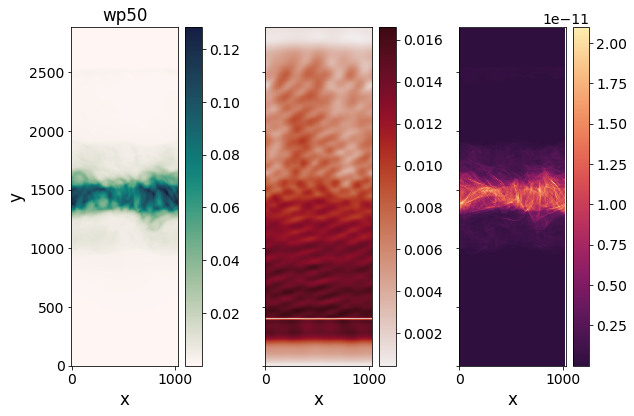

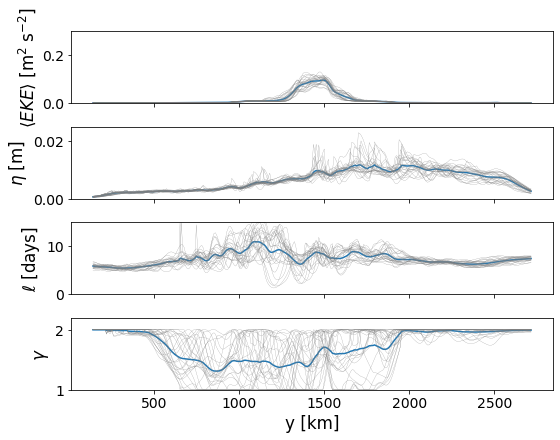

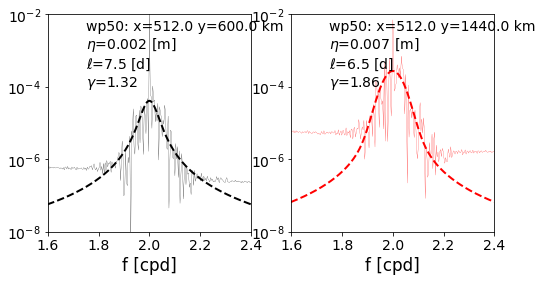

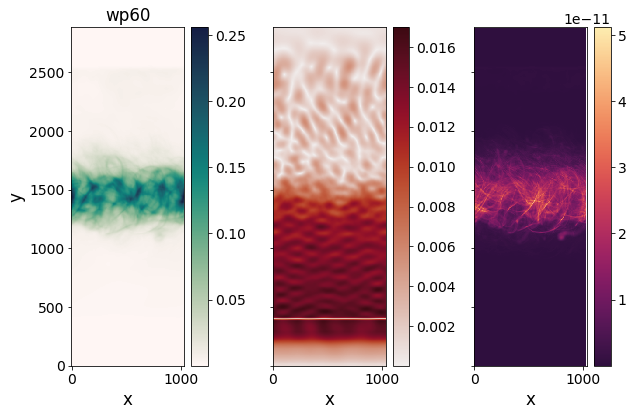

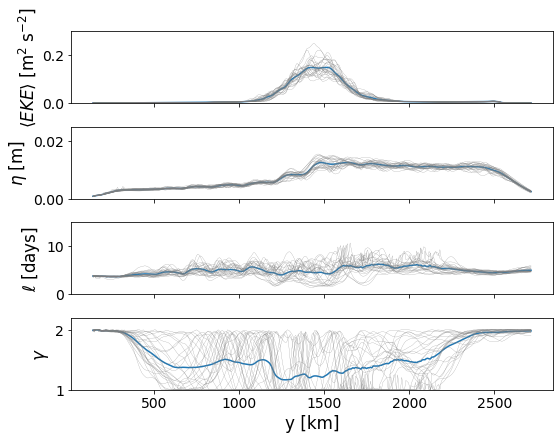

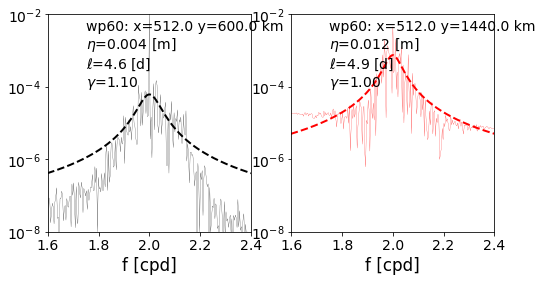

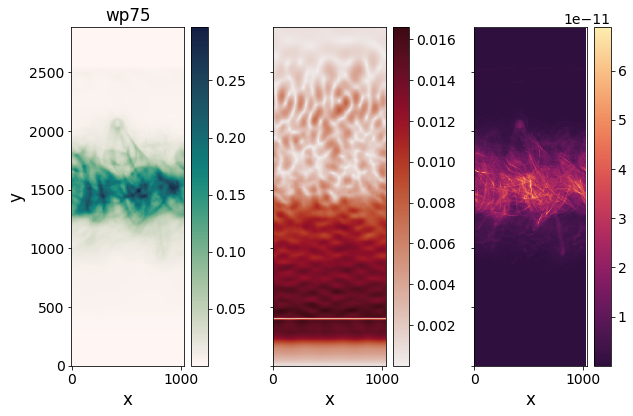

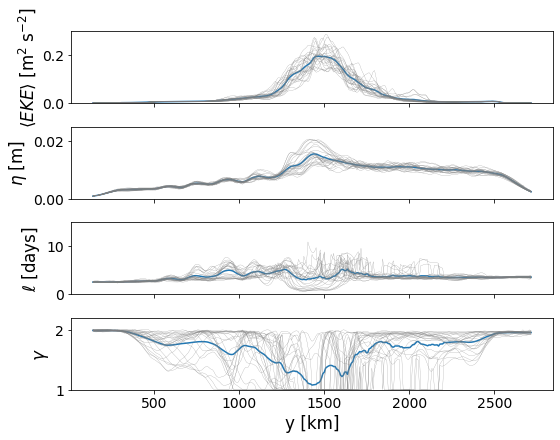

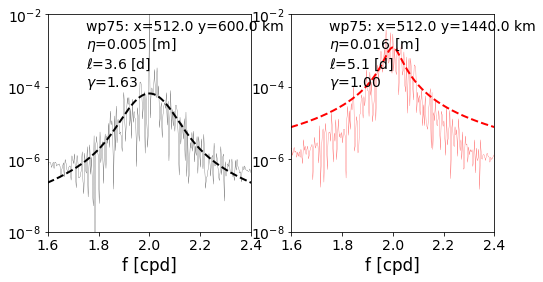

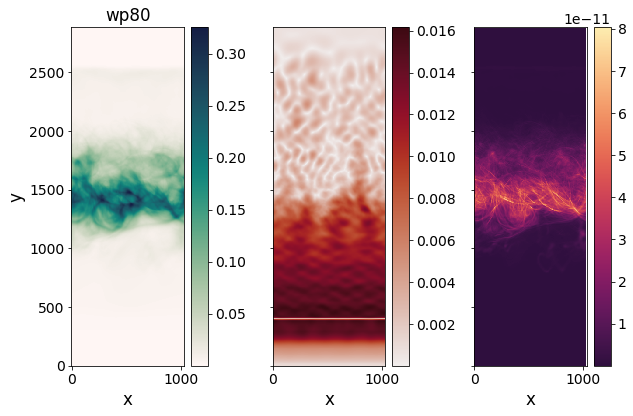

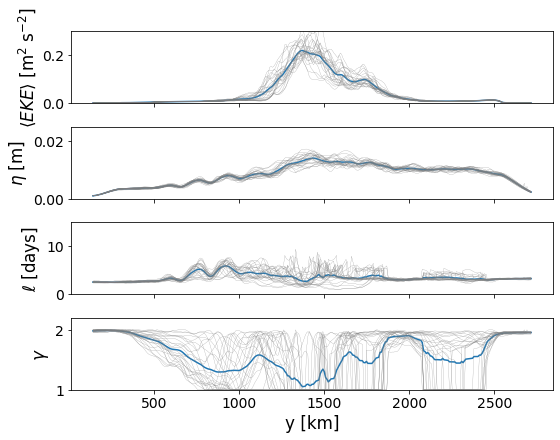

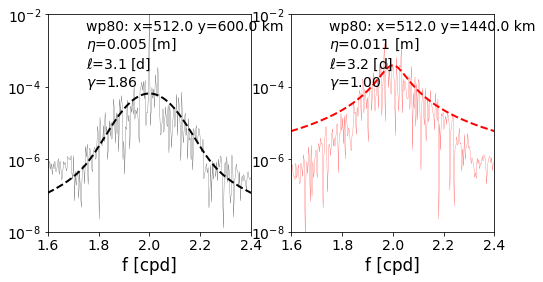

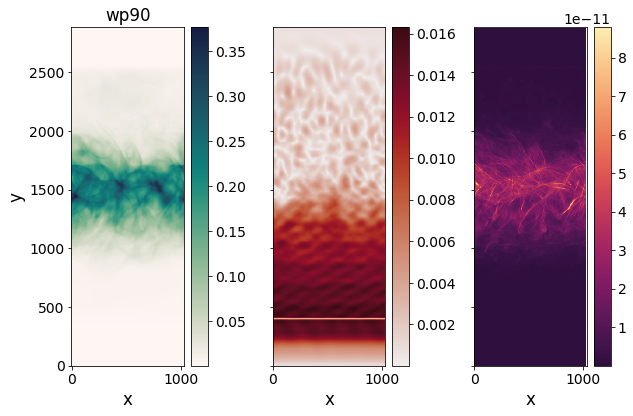

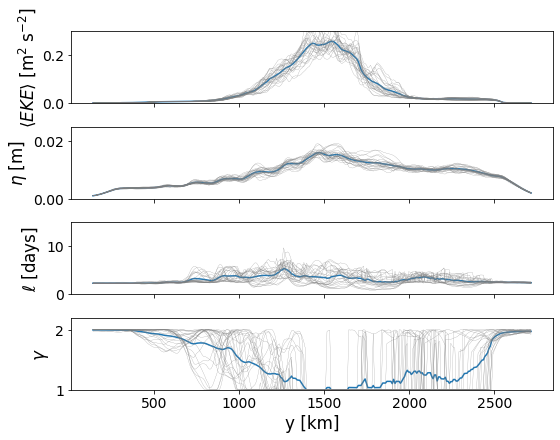

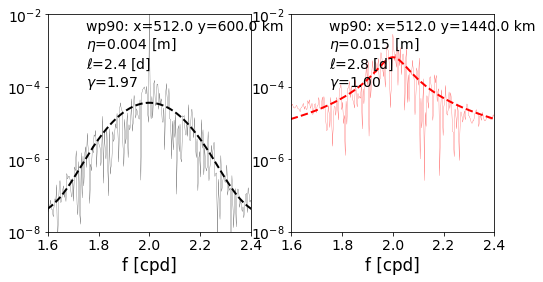

In [33]:
for scenario in scenarios:
    outfile = '{}/{}_itide_params_{}.nc'.format(datadir, scenario, covfunc.__name__)
    ds = utils.load_scenario(scenario, datadir)
    ds_nonstat = xr.open_dataset(outfile)

    print(72*'#')
    print('\t\t',scenario)
    print(72*'#')
    plot_background(ds, scenario)
    plot_params(ds_nonstat,nparams=nparams)
    
    plt.figure(figsize=(8,4))
    ax=plt.subplot(121)
    plot_site(ds, ds_nonstat, 128, 150, scenario, 'k', covfunc, dt, nparams=nparams)
    ax=plt.subplot(122)
    plot_site(ds, ds_nonstat, 128, 360, scenario, 'r', covfunc, dt, nparams=nparams)
    

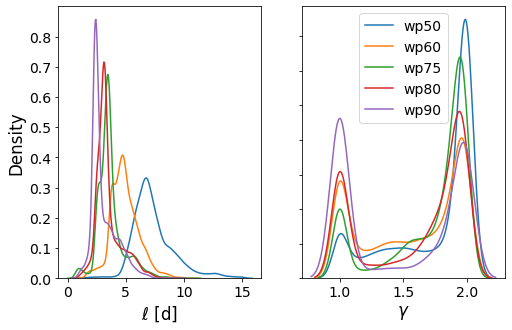

In [23]:
plt.figure(figsize=(8,5))
ax1=plt.subplot(121)
ax2=plt.subplot(122)
ax1.set_xlabel('$\ell$ [d]')
ax2.set_xlabel('$\gamma$')
for scenario in scenarios:
    outfile = '{}/{}_itide_params_{}.nc'.format(datadir, scenario, covfunc.__name__)
    ds_nonstat = xr.open_dataset(outfile)
    sns.kdeplot(ds_nonstat['data'][...,1].values.ravel(), ax=ax1)
    if nparams>2:
        sns.kdeplot(ds_nonstat['data'][...,2].values.ravel(), ax=ax2)

ax2.set_ylabel('')
ax2.set_yticklabels([])
plt.legend(scenarios)

In [54]:
plt.errorbar?

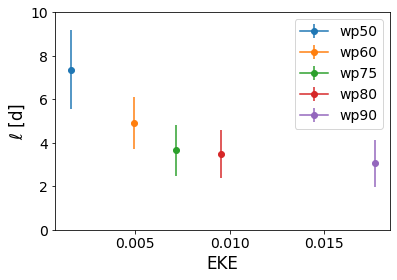

In [64]:
plt.figure()
for scenario in scenarios:
    outfile = '{}/{}_itide_params_{}.nc'.format(datadir, scenario, covfunc.__name__)
    ds_nonstat = xr.open_dataset(outfile)
    l_mean = ds_nonstat['data'][...,1].mean()
    l_std = ds_nonstat['data'][...,1].std()
    EKE = 0.5*(ds_nonstat['u_xy_lof'].var(axis=0) + ds_nonstat['v_xy_lof'].var(axis=0))
    EKE_std = np.std(EKE)
    #plt.plot(EKE.mean(), l_mean,'o')
    #plt.plot(np.percentile(EKE,90), l_mean,'o')
    plt.errorbar(np.percentile(EKE,50), l_mean, yerr=l_std,  marker='o')
plt.ylim(0,10)
plt.xlabel('EKE')
plt.ylabel('$\ell$ [d]')
plt.legend(scenarios)

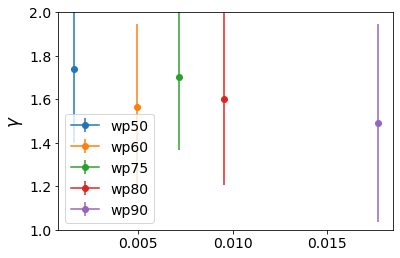

In [61]:
plt.figure()
for scenario in scenarios:
    outfile = '{}/{}_itide_params_{}.nc'.format(datadir, scenario, covfunc.__name__)
    ds_nonstat = xr.open_dataset(outfile)
    l_mean = ds_nonstat['data'][...,2].mean()
    l_std = ds_nonstat['data'][...,2].std()
    EKE = 0.5*(ds_nonstat['u_xy_lof'].var(axis=0) + ds_nonstat['v_xy_lof'].var(axis=0))
    EKE_std = np.std(EKE)
    #plt.plot(EKE.mean(), l_mean,'o')
    #plt.plot(np.percentile(EKE,90), l_mean,'o')
    plt.errorbar(np.percentile(EKE,50), l_mean, yerr=l_std,  marker='o')
plt.ylim(1,2)
plt.ylabel('$\gamma$')
plt.legend(scenarios)

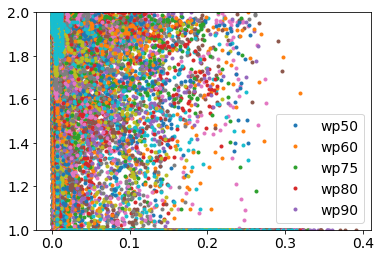

In [63]:
plt.figure()
for scenario in scenarios:
    outfile = '{}/{}_itide_params_{}.nc'.format(datadir, scenario, covfunc.__name__)
    ds_nonstat = xr.open_dataset(outfile)
    EKE = 0.5*(ds_nonstat['u_xy_lof'].var(axis=0) + ds_nonstat['v_xy_lof'].var(axis=0))
    
    EKE_cum = EKE.cumsum(axis=1)
    
    #idx = EKE.values.ravel()>0.05
    #plt.plot(EKE.values.ravel()[idx], ds_nonstat['data'][...,1].values.ravel()[idx],'.')
    #plt.plot(EKE_cum, ds_nonstat['data'][...,1],'.')
    plt.plot(EKE, ds_nonstat['data'][...,2],'.')
    
plt.ylim(1,2)
plt.legend(scenarios)

# Lorentzian model

In [65]:
datadir = '../../SouthernOceanIWaves/DATA'
# covfunc = nsit.itmodel_gamma
covfunc = nsit.itmodel_lorentzian
nparams=2
dt=1/72.
scenarios = ['wp50','wp60','wp75','wp80','wp90']

../../SouthernOceanIWaves/DATA/wp50-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp50-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp50-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp50-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp50-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp50-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp50-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp50-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp50-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
########################################################################
		 wp50
########################################################################


/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


../../SouthernOceanIWaves/DATA/wp60-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp60-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp60-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp60-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp60-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp60-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp60-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp60-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp60-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
########################################################################
		 wp60
########################################################################


/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


../../SouthernOceanIWaves/DATA/wp75-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp75-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp75-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp75-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp75-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp75-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp75-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp75-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp75-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
########################################################################
		 wp75
########################################################################


/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


../../SouthernOceanIWaves/DATA/wp80-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp80-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp80-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp80-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp80-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp80-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp80-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp80-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp80-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
########################################################################
		 wp80
########################################################################


/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


../../SouthernOceanIWaves/DATA/wp90-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp90-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp90-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp90-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp90-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp90-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp90-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp90-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp90-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
########################################################################
		 wp90
########################################################################


/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


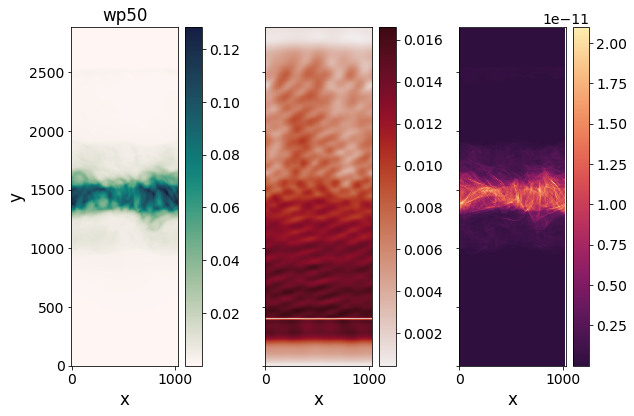

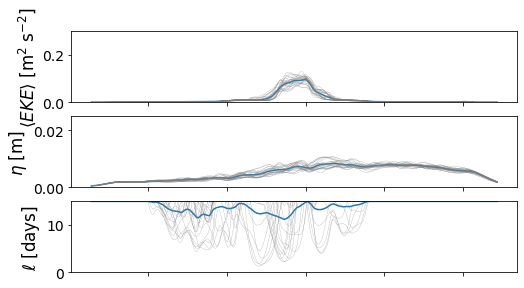

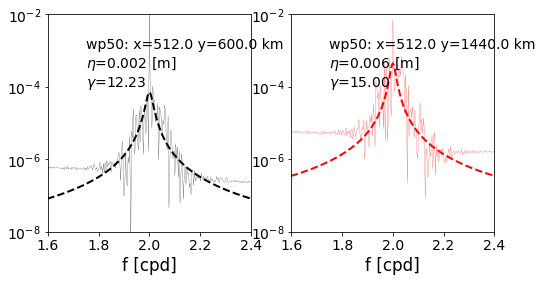

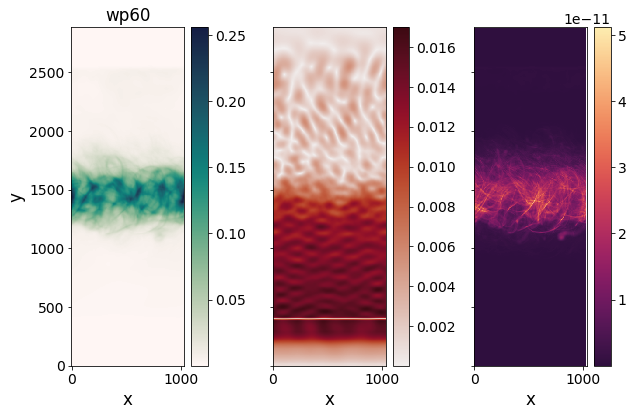

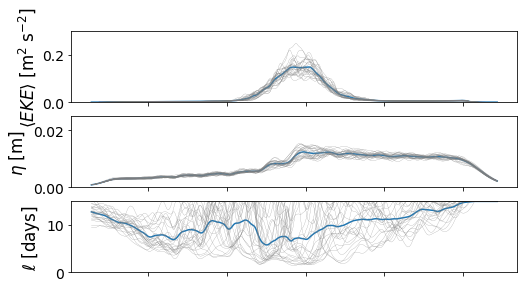

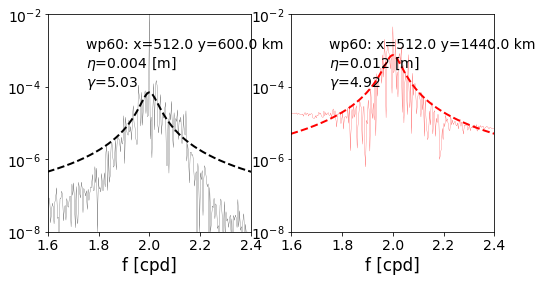

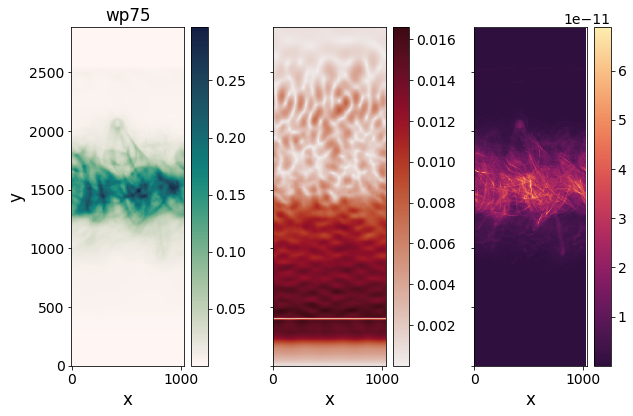

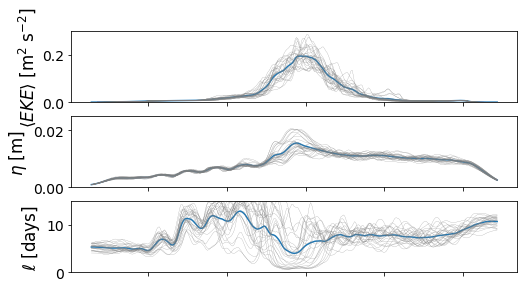

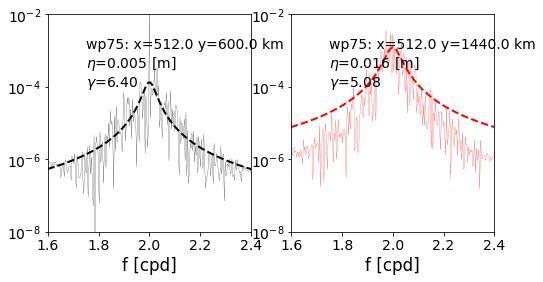

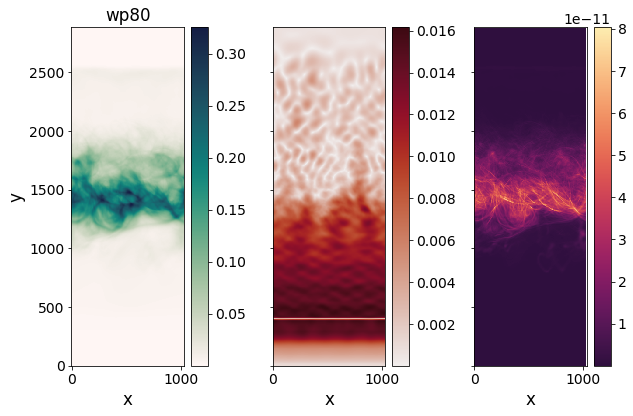

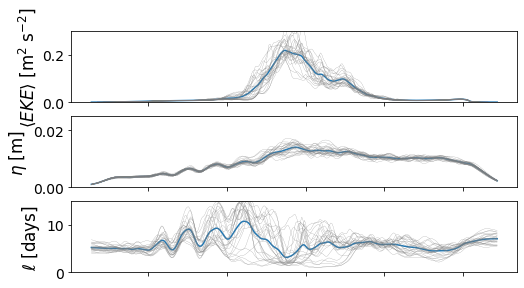

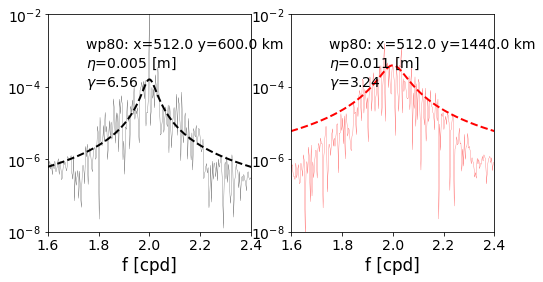

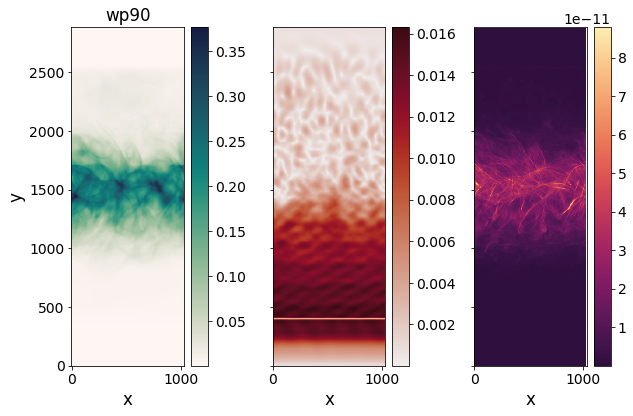

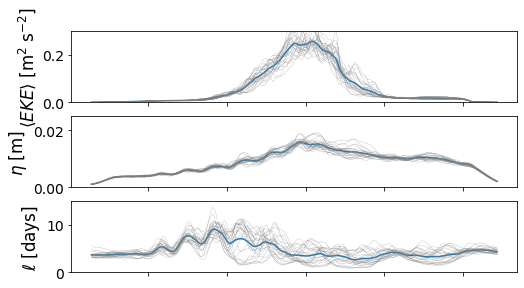

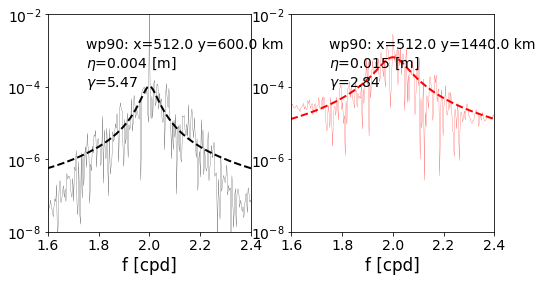

In [66]:

for scenario in scenarios:
    outfile = '{}/{}_itide_params_{}.nc'.format(datadir, scenario, covfunc.__name__)
    ds = utils.load_scenario(scenario, datadir)
    ds_nonstat = xr.open_dataset(outfile)

    print(72*'#')
    print('\t\t',scenario)
    print(72*'#')
    plot_background(ds, scenario)
    plot_params(ds_nonstat,nparams=nparams)
    
    plt.figure(figsize=(8,4))
    ax=plt.subplot(121)
    plot_site(ds, ds_nonstat, 128, 150, scenario, 'k', covfunc, dt, nparams=nparams)
    ax=plt.subplot(122)
    plot_site(ds, ds_nonstat, 128, 360, scenario, 'r', covfunc, dt, nparams=nparams)
    

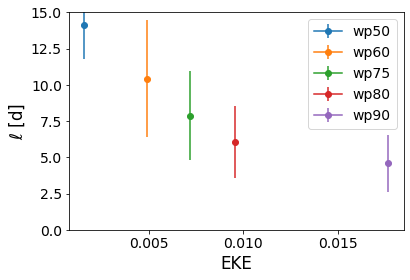

In [68]:
plt.figure()
for scenario in scenarios:
    outfile = '{}/{}_itide_params_{}.nc'.format(datadir, scenario, covfunc.__name__)
    ds_nonstat = xr.open_dataset(outfile)
    l_mean = ds_nonstat['data'][...,1].mean()
    l_std = ds_nonstat['data'][...,1].std()
    EKE = 0.5*(ds_nonstat['u_xy_lof'].var(axis=0) + ds_nonstat['v_xy_lof'].var(axis=0))
    EKE_std = np.std(EKE)
    #plt.plot(EKE.mean(), l_mean,'o')
    #plt.plot(np.percentile(EKE,90), l_mean,'o')
    plt.errorbar(np.percentile(EKE,50), l_mean, yerr=l_std,  marker='o')
plt.ylim(0,15)
plt.xlabel('EKE')
plt.ylabel('$\ell$ [d]')
plt.legend(scenarios)

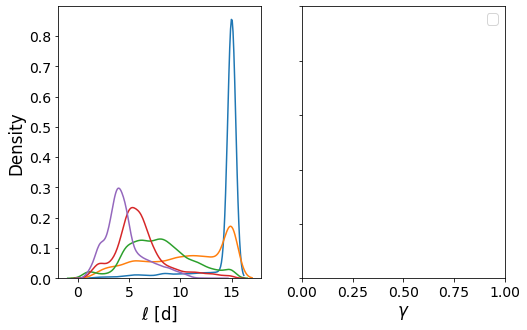

In [20]:
# plt.hist(ds_nonstat['data'][...,0].values.ravel(), bins = np.linspace(0,0.02,20))
# plt.hist(ds_nonstat['data'][...,1].values.ravel(), bins = np.linspace(1,10,20))
plt.figure(figsize=(8,5))
ax1=plt.subplot(121)
ax2=plt.subplot(122)
ax1.set_xlabel('$\ell$ [d]')
ax2.set_xlabel('$\gamma$')
for scenario in scenarios:
    outfile = '{}/{}_itide_params_{}.nc'.format(datadir, scenario, covfunc.__name__)
    ds_nonstat = xr.open_dataset(outfile)
    sns.kdeplot(ds_nonstat['data'][...,1].values.ravel(), ax=ax1)
    if nparams>2:
        sns.kdeplot(ds_nonstat['data'][...,2].values.ravel(), ax=ax2)

ax2.set_ylabel('')
ax2.set_yticklabels([])
plt.legend(scenarios)

In [83]:
ds_nonstat['data'][...,1].values.ravel()

array([2.33874238, 2.2213374 , 2.26248128, ..., 2.64134358, 2.39267998,
       2.45998659])

In [82]:
ds_nonstat

<xarray.Dataset>
Dimensions:       (x: 26, y: 323, time: 140, params: 3)
Coordinates:
  * x             (x) float64 0.0 40.0 80.0 120.0 ... 880.0 920.0 960.0 1e+03
  * y             (y) float64 140.0 148.0 156.0 ... 2.7e+03 2.708e+03 2.716e+03
  * time          (time) float64 21.0 23.0 25.0 27.0 ... 293.0 295.0 297.0 299.0
  * params        (params) int64 0 1 2
Data variables:
    v_xy_lof      (time, y, x) float32 -0.001071 -0.0006741 ... 0.002109
    v_xy_cos      (time, y, x) float32 ...
    v_xy_sin      (time, y, x) float32 ...
    u_xy_lof      (time, y, x) float32 0.002078 0.0025 ... -0.01546 -0.01624
    u_xy_cos      (time, y, x) float32 ...
    u_xy_sin      (time, y, x) float32 ...
    ssh_lof       (time, y, x) float32 ...
    ssh_cos       (time, y, x) float32 ...
    ssh_sin       (time, y, x) float32 ...
    ssh_cos_stat  (y, x) float32 0.005005 0.004906 ... -0.000482 -0.0004854
    ssh_sin_stat  (y, x) float32 0.00211 0.002148 ... -0.0006024 -0.0004134
    data          (y, x, params) float64 0.0009823 2.339 1.98 ... 2.46 1.948